In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.fft import fft2, ifft2
from matplotlib import animation

c0 =  0.50049645


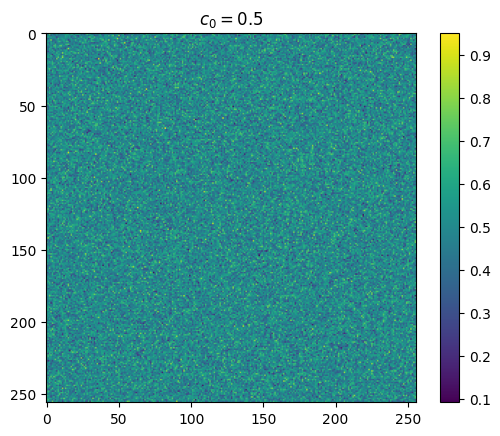

In [3]:
# 初期値の設定

n_steps = 10000  # ステップ数
dt = 0.1  # 時間刻み
N = 256  # サイズ
dx = 1.0
noise = 0.1
c0 = 0.5
rng = np.random.default_rng(12345)  # the seed of random numbers generator


c_hat = np.empty((N, N), dtype=np.complex64)
dfdc_hat = np.empty((N, N), dtype=np.complex64)
c = np.empty((n_steps, N, N), dtype=np.float32)
L = N * dx

c[0] = c0 + noise * rng.standard_normal(c[0].shape)

print("c0 = ", c[0].sum() * dx**2 / L**2)

plt.imshow(c[0])
plt.colorbar(cmap="RdBu_r")
plt.title("$c_0=%.1f$" % c0)
plt.savefig("cahn-hilliard-input.png")
plt.show()

In [ ]:
def finterf(c_hat, kappa, K2):
    """内部自由エネルギー密度

    f(c) = Wc^2(1-c)^2
    """
    return kappa * ifft2(K2 * c_hat**2).real


def fbulk(c, W):
    """バルクの自由エネルギー密度

    f(c) = Wc^2(1-c)^2

    Parameters
    ----------
    c : _type_
        _description_
    W : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    return W * c**2 * (1 - c) * c**2


def dfdc(c, W):
    """バルクの自由エネルギー密度の微分

    Parameters
    ----------
    c : _type_
        _description_
    W : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    return 2 * W * (c * (1 - c) ** 2 - (1 - c) * c**2)



In [5]:
W = 2.0
M = 1.0  # mobility
kappa = 0.5  # gradient coeficient

# 2次元フーリエ変換のための波数ベクトルの設定
kx = ky = np.fft.fftfreq(N, d=dx) * 2 * np.pi
K = np.array(np.meshgrid(kx, ky, indexing="ij"), dtype=np.float32)
K2 = np.sum(K * K, axis=0, dtype=np.float32)

# The anti-aliasing factor
kmax_dealias = kx.max() * 2.0 / 3.0  # The Nyquist mode
dealias = np.array(
    (np.abs(K[0]) < kmax_dealias) * (np.abs(K[1]) < kmax_dealias), dtype=bool
)

c_hat[:] = fft2(c[0])
for i in tqdm(range(1, n_steps)):
    dfdc_hat[:] = fft2(dfdc(c[i - 1], W))  # the FT of the derivative
    dfdc_hat *= dealias  # dealising
    c_hat[:] = (c_hat - dt * K2 * M * dfdc_hat) / (
        1 + dt * M * kappa * K2**2
    )  # updating in time
    c[i] = ifft2(c_hat).real  # inverse fourier transform

100%|██████████| 9999/9999 [00:09<00:00, 1097.76it/s]


c =  0.5004964
relative_error =  1.1909105e-07


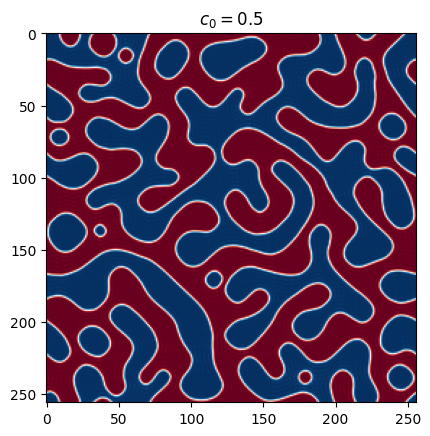

In [7]:
print("c = ", c[-1].sum() * dx**2 / L**2)

print("relative_error = ", np.abs(c[-1].sum() - c[0].sum()) / c[0].sum())
plt.imshow(c[-1], cmap="RdBu_r", vmin=0.0, vmax=1.0)
plt.title("$c_0=%.1f$" % c0)
plt.savefig("cahn-hilliard-c0-%.1f.png" % c0)
plt.show()

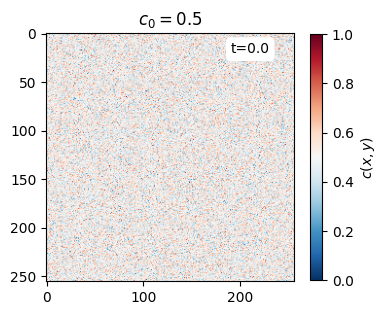

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.imshow(c[0], cmap="RdBu_r", vmin=0.0, vmax=1.0)
cb = fig.colorbar(im, ax=ax, label=r"$c(x,y)$", shrink=0.8)
tx = ax.text(
    190, 20, "t={:.1f}".format(0.0), bbox=dict(boxstyle="round", ec="white", fc="white")
)
ax.set_title(r"$c_0=%.1f$" % c0)
plt.show()

def animate(i):
    im.set_data(c[5*i])
    im.set_clim(0.0, 1.0)
    tx.set_text("t={:.1f}".format(5*i*dt))
    return fig

ani = animation.FuncAnimation(fig, animate, frames=199, interval=50)
ani.save("ch-c0=" + str(c0) + ".gif", writer="pillow", fps=24, dpi=100)